## Portfolio NLP
##### Idee: Inhaltliche Klassifikation von Zeitungsartikeln - Zeitungsartikel sollen automatisch je nach Titeln und kurzer Beschreibung in Kategorien eingeteilt werden.
##### Dabei werden verschiedene ML Modelle getestet, evaluiert und auf die Kompatibilität mit dem Anwendungsfall überprüft.
##### Für die Modelle nutzen wir einen Datensatz von Kaggle. Dieser enthält etwa 210.000 Daten. Der Datensatz besteht aus Zeitungsartikel Überschriften und kurze Beschreibungen in englischer Sprache. Die Daten sind aus den Jahren 2012 – 2022.

##### Datensatz: News Category Dataset | Kaggle

##### Wenn das für unseren Anwendungsfall optimale Modell gefunden wurde, werden wir eine Anwenderoberfläche mit dem Framework Streamlit entwickeln. Der Benutzer soll einen Titel und (wenn vorhanden) eine kurze Beschreibung oder das Abstract des Artikels eingeben. Daraufhin gibt das Modell gibt eine Kategorie als Antwort zurück. Darüber hinaus werden wir die Anwendung deployen, damit jeder unsere Anwendung nutzen kann.

##### Github Repo: GitHub - bila9630/NLP-Project

##### Gruppe: Hannah Schult, Duc Viet Kieu, Marvin Spurk, Caroline Schmidt, Sofie Pischl

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
nltk.download('punkt')
STOPWORDS = set(stopwords.words('english'))

from sklearn.utils import shuffle


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data = pd.read_json('C:\\Users\\schul\\Desktop\\DHBW\\Semester5\\Aktuelle Data Science\\Portfolio\\archive\\News_Category_Dataset_v3.json', lines=True)
data.head(3)

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23


In [3]:
# Get a series of unique values in column 'Age' of the dataframe
uniqueValues = data['category'].unique()
print('Unique elements in column "category" ')
print(uniqueValues)

Unique elements in column "category" 
['U.S. NEWS' 'COMEDY' 'PARENTING' 'WORLD NEWS' 'CULTURE & ARTS' 'TECH'
 'SPORTS' 'ENTERTAINMENT' 'POLITICS' 'WEIRD NEWS' 'ENVIRONMENT'
 'EDUCATION' 'CRIME' 'SCIENCE' 'WELLNESS' 'BUSINESS' 'STYLE & BEAUTY'
 'FOOD & DRINK' 'MEDIA' 'QUEER VOICES' 'HOME & LIVING' 'WOMEN'
 'BLACK VOICES' 'TRAVEL' 'MONEY' 'RELIGION' 'LATINO VOICES' 'IMPACT'
 'WEDDINGS' 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'DIVORCE']


In [4]:
# Count unique values in column 'Age' of the dataframe
uniqueValues_number = data['category'].nunique()
print('Number of unique values in column "category" of the dataframe : ')
print(uniqueValues_number)

Number of unique values in column "category" of the dataframe : 
42


In [5]:
freq = data['category'].value_counts() 
print(freq) 

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

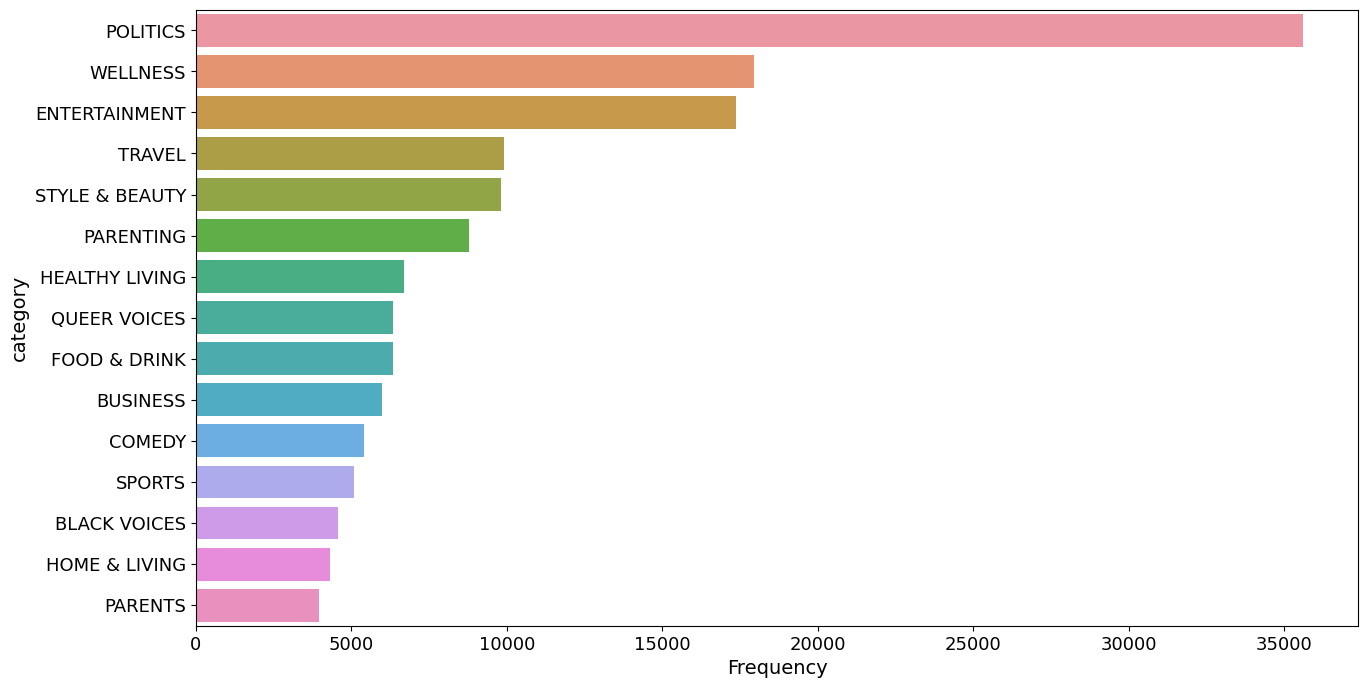

In [6]:
# bar cities
plt.figure(figsize=(15,8))
sns.barplot(data=data['category'].value_counts().head(15).reset_index(),
        y='index',x='category')
plt.xticks(fontsize=13)
plt.xlabel("Frequency",fontsize=14)
plt.yticks(fontsize=13)
plt.ylabel("category",fontsize=14)
# plt.savefig('pie_cities.png')
plt.show()

## Politik kürzen

In [7]:
data.drop(['authors','link','date'],axis=1,inplace=True)
data['Text'] = data['headline'] + data['short_description']
data.drop(['headline','short_description'],axis=1,inplace=True)

In [8]:
data.head()

,category,Text
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li..."
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...
3,PARENTING,The Funniest Tweets From Parents This Week (Se...
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...


In [9]:
#Handle Multiclass Imbalance Datasets
def Imbalance_to_balance(df,No_of_sample):
    
    # Dict used to store data class wise
    df_dic = {}
    
    # Create dataframe to store data after sampling
    df_new = pd.DataFrame(columns=['category','Text'])
    
    #cal use to iterate over each class in target col
    for cal in df['category'].unique():
        
        # Filtering class from target which has more than No_of_sample row
        if df[df['category'] == cal].shape[0] > No_of_sample:
            
            #Extracting 4000 sample class wise from dataframe
            df_dic[cal] = df[df['category'] == cal].sample(No_of_sample,random_state=42,ignore_index=True)
    
    # store all class which has more than 4000 row
    cal = list(df_dic.keys())
    for classs in cal:
        
        #concate data of each class into new data frame
        df_new = pd.concat([df_new,df_dic[f"{classs}"]],axis=0)
    
    return shuffle(df_new)

In [10]:
df= Imbalance_to_balance(data,8000)

In [11]:
df['Text'].head()

1393    Trump Boasts He Likely Saved 'Billions' Of Liv...
509     Teaching Your Teen Money SkillsHere are eight ...
3163    20 Unique Places That Prove Our Planet Is Awes...
928     RNC Chair Says 'People Just Don't Care' About ...
2623    Healthy And Vegan New York Eats, Part 1New Yor...
Name: Text, dtype: object

In [12]:
df['category'].value_counts()

POLITICS          8000
PARENTING         8000
TRAVEL            8000
ENTERTAINMENT     8000
STYLE & BEAUTY    8000
WELLNESS          8000
Name: category, dtype: int64

In [13]:
max_len = df['Text'].apply(lambda x:len(x.split())).max()
max_len

244

In [14]:
import re
def process_text(text):
    text = text.lower().replace('\n',' ').replace('\r','').strip()
    text = re.sub(' +', ' ', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'[0-9]','',text)
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    
    text = " ".join(filtered_sentence)
    return text

In [15]:
df['Text'] = df['Text'].apply(lambda x:process_text(x))

In [16]:
max_len = df['Text'].apply(lambda x:len(x.split())).max()
max_len

140

In [17]:
label_dic = {}
for key, label in enumerate(df['category'].unique()):
    label_dic[label] = key

In [18]:
print(label_dic)

{'POLITICS': 0, 'PARENTING': 1, 'TRAVEL': 2, 'ENTERTAINMENT': 3, 'STYLE & BEAUTY': 4, 'WELLNESS': 5}


In [29]:
label_dic

{'POLITICS': 0,
 'PARENTING': 1,
 'TRAVEL': 2,
 'ENTERTAINMENT': 3,
 'STYLE & BEAUTY': 4,
 'WELLNESS': 5}

### Models

In [36]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding
from xgboost import XGBRFClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn import svm


models = []
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
models.append(("ExtraTreeClassifier",ExtraTreeClassifier()))
#models.append(("XGBRFClassifier",XGBRFClassifier()))
#models.append(("XGBClassifier",XGBClassifier()))
models.append(("ExtraTreeClassifier",ExtraTreeClassifier()))
models.append(("LinearSVC",LinearSVC()))
models.append(("KNeighbors",KNeighborsClassifier()))


# results = []
# namwarnings[]
# for name,model in models:
#     result = cross_val_score(model, X, y,  cv=5)
#     names.append(name)
#     results.append(result)

# for i in range(len(names)):
#     print(names[i],results[i].mean())

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [21]:
max_len = df['Text'].apply(lambda x:len(x.split())).max()
max_len

140

## TF-IDF

In [22]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tokenizer = Tokenizer()

In [23]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 1000
max_len = int(round(df['Text'].apply(lambda x: len(str(x).split())).max()))

In [24]:
def TF_IDF_ML(X,y):
    tokenizer.fit_on_texts(X)
    word_index = tokenizer.word_index
    vocab_size = len(tokenizer.word_index) + 1
    
    #print("Vocabulary Size :", vocab_size)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=42)
    
    
    X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = max_len)
    X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = max_len)
    return X_train, X_test, y_train, y_test

In [25]:
X_train, X_test, y_train, y_test = TF_IDF_ML(df['Text'],df['category'])

In [26]:
from sklearn.metrics import classification_report
def Train_Model(model):
    model.fit(X_train,y_train)
    return print(classification_report(y_test,model.predict(X_test)))

In [37]:
for model in models:
    print(model[0])
    print(Train_Model(model[1]))
    print("\n\n")

DecisionTree
                precision    recall  f1-score   support

 ENTERTAINMENT       0.37      0.34      0.36      2504
     PARENTING       0.23      0.23      0.23      2371
      POLITICS       0.27      0.27      0.27      2321
STYLE & BEAUTY       0.29      0.29      0.29      2436
        TRAVEL       0.21      0.21      0.21      2423
      WELLNESS       0.23      0.24      0.24      2345

      accuracy                           0.27     14400
     macro avg       0.27      0.26      0.27     14400
  weighted avg       0.27      0.27      0.27     14400

None



RandomForest
                precision    recall  f1-score   support

 ENTERTAINMENT       0.51      0.49      0.50      2504
     PARENTING       0.32      0.38      0.35      2371
      POLITICS       0.38      0.33      0.35      2321
STYLE & BEAUTY       0.37      0.48      0.42      2436
        TRAVEL       0.30      0.21      0.25      2423
      WELLNESS       0.30      0.29      0.29      2345

      acc

DecisionTree
                precision    recall  f1-score   support

 ENTERTAINMENT       0.37      0.34      0.36      2504
     PARENTING       0.23      0.23      0.23      2371
      POLITICS       0.27      0.27      0.27      2321
STYLE & BEAUTY       0.29      0.29      0.29      2436
        TRAVEL       0.21      0.21      0.21      2423
      WELLNESS       0.23      0.24      0.24      2345

      accuracy                           0.27     14400
     macro avg       0.27      0.26      0.27     14400
  weighted avg       0.27      0.27      0.27     14400

None



RandomForest
                precision    recall  f1-score   support

 ENTERTAINMENT       0.51      0.49      0.50      2504
     PARENTING       0.32      0.38      0.35      2371
      POLITICS       0.38      0.33      0.35      2321
STYLE & BEAUTY       0.37      0.48      0.42      2436
        TRAVEL       0.30      0.21      0.25      2423
      WELLNESS       0.30      0.29      0.29      2345

      accuracy                           0.36     14400
     macro avg       0.36      0.36      0.36     14400
  weighted avg       0.36      0.36      0.36     14400

None



ExtraTreeClassifier
                precision    recall  f1-score   support

 ENTERTAINMENT       0.33      0.31      0.32      2504
     PARENTING       0.22      0.22      0.22      2371
      POLITICS       0.23      0.24      0.23      2321
STYLE & BEAUTY       0.26      0.25      0.26      2436
        TRAVEL       0.21      0.20      0.20      2423
      WELLNESS       0.22      0.24      0.23      2345

      accuracy                           0.24     14400
     macro avg       0.24      0.24      0.24     14400
  weighted avg       0.25      0.24      0.24     14400

None



ExtraTreeClassifier
                precision    recall  f1-score   support

 ENTERTAINMENT       0.32      0.30      0.31      2504
     PARENTING       0.21      0.22      0.22      2371
      POLITICS       0.23      0.24      0.23      2321
STYLE & BEAUTY       0.25      0.25      0.25      2436
        TRAVEL       0.20      0.20      0.20      2423
      WELLNESS       0.22      0.22      0.22      2345

      accuracy                           0.24     14400
     macro avg       0.24      0.24      0.24     14400
  weighted avg       0.24      0.24      0.24     14400

None



LinearSVC
                precision    recall  f1-score   support

 ENTERTAINMENT       0.30      0.14      0.19      2504
     PARENTING       0.22      0.03      0.06      2371
      POLITICS       0.21      0.30      0.25      2321
STYLE & BEAUTY       0.22      0.12      0.16      2436
        TRAVEL       0.19      0.20      0.20      2423
      WELLNESS       0.19      0.47      0.27      2345

      accuracy                           0.21     14400
     macro avg       0.22      0.21      0.19     14400
  weighted avg       0.22      0.21      0.19     14400

None



KNeighbors
                precision    recall  f1-score   support

 ENTERTAINMENT       0.34      0.45      0.39      2504
     PARENTING       0.23      0.34      0.27      2371
      POLITICS       0.25      0.25      0.25      2321
STYLE & BEAUTY       0.30      0.24      0.26      2436
        TRAVEL       0.21      0.13      0.16      2423
      WELLNESS       0.27      0.23      0.24      2345

      accuracy                           0.27     14400
     macro avg       0.27      0.27      0.26     14400
  weighted avg       0.27      0.27      0.26     14400

None